In [4]:
!pip install dscribe ase scikit-learn xgboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 8.6 MB/s eta 0:00:00


In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ML_domain_of_applicability/LI-ion batteries/work/NCM-ML')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from ase import Atoms
from dscribe.descriptors import SOAP

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [6]:
data = pd.read_csv('NMC_numerical_new.csv')
data.head()

,Li,Ni,Co,Mn,M,LC_a,LC_c,CV,CD,V_min,...,Mr,no_electron_M,EN_M,No_iso_dopant,E_ion_dopant,EA_dopant,AR_dopant,IR_dopant,IC,EC
0,1.19,0.130,0.13,0.49,0.010,2.8543,14.2460,100.513,50.0,2.0,...,82.47,37,0.82,20,403,0.485,265,235,220.33,207.91
1,1.17,0.130,0.13,0.44,0.030,2.8547,14.2460,100.541,50.0,2.0,...,79.58,37,0.82,20,403,0.485,265,235,236.70,228.28
2,1.15,0.130,0.13,0.39,0.050,2.8605,14.2414,100.918,50.0,2.0,...,76.70,37,0.82,20,403,0.485,265,235,223.04,218.10
3,1.00,0.450,0.10,0.43,0.020,2.8804,14.2899,102.675,36.0,3.0,...,94.87,40,1.33,20,640,0.433,206,155,180.07,178.22
4,1.00,0.796,0.10,0.10,0.005,2.8774,14.2216,101.972,40.0,2.8,...,96.99,41,1.60,24,652,0.917,198,145,216.65,204.60


In [7]:
def create_structure(row):
    multiplier = 100
    Li = int(row['Li'] * multiplier)
    Ni = int(row['Ni'] * multiplier)
    Co = int(row['Co'] * multiplier)
    Mn = int(row['Mn'] * multiplier)

    formula = f"Li{Li}Ni{Ni}Co{Co}Mn{Mn}"
    structure = Atoms(formula)
    return structure

structures = data.apply(create_structure, axis=1)

In [8]:
soap = SOAP(
    species=["Li", "Ni", "Co", "Mn"],
    r_cut=6.0,  # Radial cutoff (adjust based on your system)
    n_max=6,   # Reduce the radial basis functions
    l_max=4,   # Reduce the spherical harmonics
    periodic=False
)

In [9]:
soap_features = []

for structure in structures:
    soap_vector = soap.create(structure)
    soap_features.append(soap_vector)


max_length = max(arr.shape[0] for arr in soap_features)
soap_features_padded = [np.pad(arr, ((0, max_length - arr.shape[0]), (0, 0)), mode='constant') for arr in soap_features]


soap_features_padded = np.array(soap_features_padded)

np.save("soap_features.npy", soap_features_padded)

# Error functions

In [10]:
def calculate_errors(y_train, y_train_pred, y_test, y_test_pred):
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    return rmse_train, rmse_test, r2_test

# Plotting functions

In [11]:
def plot_IC_curve(y_IC_train, y_train_pred, y_IC_test, y_test_pred, rmse_train, rmse_test, r2_test, model_name):
    results_train = pd.DataFrame({
        "Experimental": y_IC_train,
        "Predicted": y_train_pred
    })
    results_test = pd.DataFrame({
        "Experimental": y_IC_test,
        "Predicted": y_test_pred
    })

    plt.figure(figsize=(8, 8))
    plt.axis([50, 330, 50, 330])

    plt.scatter(x=results_train["Experimental"], y=results_train["Predicted"], c='deepskyblue', label='Training')
    plt.scatter(x=results_test["Experimental"], y=results_test["Predicted"], c='blue', label='Test')

    plt.plot([50, 360], [50, 360], label='True Line', color='red', linewidth=2)

    plt.legend(loc='lower right')
    plt.xlabel(r'Experimental Initial Charge Capacity (IC) (mAh/g)')
    plt.ylabel(r'Predicted Initial Charge Capacity (IC) (mAh/g)')
    plt.title(f'{model_name} - IC Results Plot')

    plt.text(60, 260, f"$RMSE_{{train}} = {rmse_train:.2f} \, mAh/g$\n" +
            f"$RMSE_{{test}} = {rmse_test:.2f} \, mAh/g$\n" +
            f"$R^2_{{test}} = {r2_test:.2f}$", fontsize=12)

    plt.savefig(f'{model_name}-IC-Predicted-vs-Test.png', dpi=1000)

    plt.show()

In [12]:
def plot_EC_curve(y_EC_train, y_train_pred, y_EC_test, y_test_pred, rmse_train, rmse_test, r2_test, model_name):
    results_train = pd.DataFrame({
        "Experimental": y_EC_train,
        "Predicted": y_train_pred
    })
    results_test = pd.DataFrame({
        "Experimental": y_EC_test,
        "Predicted": y_test_pred
    })

    plt.figure(figsize=(8, 8))
    plt.axis([50, 330, 50, 330])

    plt.scatter(x=results_train["Experimental"], y=results_train["Predicted"], c='deepskyblue', label='Training')
    plt.scatter(x=results_test["Experimental"], y=results_test["Predicted"], c='blue', label='Test')

    plt.plot([50, 360], [50, 360], label='True Line', color='red', linewidth=2)

    plt.legend(loc='lower right')
    plt.xlabel(r'Experimental 50th cycle discharge Capacity (EC) (mAh/g)')
    plt.ylabel(r'Predicted 50th cycle discharge Capacity (EC) (mAh/g)')
    plt.title(f'{model_name} - EC Results Plot')

    plt.text(60, 260, f"$RMSE_{{train}} = {rmse_train:.2f} \, mAh/g$\n" +
            f"$RMSE_{{test}} = {rmse_test:.2f} \, mAh/g$\n" +
            f"$R^2_{{test}} = {r2_test:.2f}$", fontsize=12)

    plt.savefig(f'{model_name}-EC-Predicted-vs-Test.png', dpi=1000)

    plt.show()

In [13]:
soap_features = np.load("soap_features.npy")
data = pd.read_csv('NMC_numerical_new.csv')

target_ic = data['IC'].values
target_ec = data['EC'].values

additional_features = data.drop(columns=['IC', 'EC']).select_dtypes(include=[np.number]).values

soap_features_flat = soap_features.reshape(soap_features.shape[0], -1)
combined_features = np.concatenate((soap_features_flat, additional_features), axis=1)

X_train, X_test, y_train_ic, y_test_ic = train_test_split(combined_features, target_ic, test_size=0.2, random_state=42)
_, _, y_train_ec, y_test_ec = train_test_split(combined_features, target_ec, test_size=0.2, random_state=42)

# Random Forest

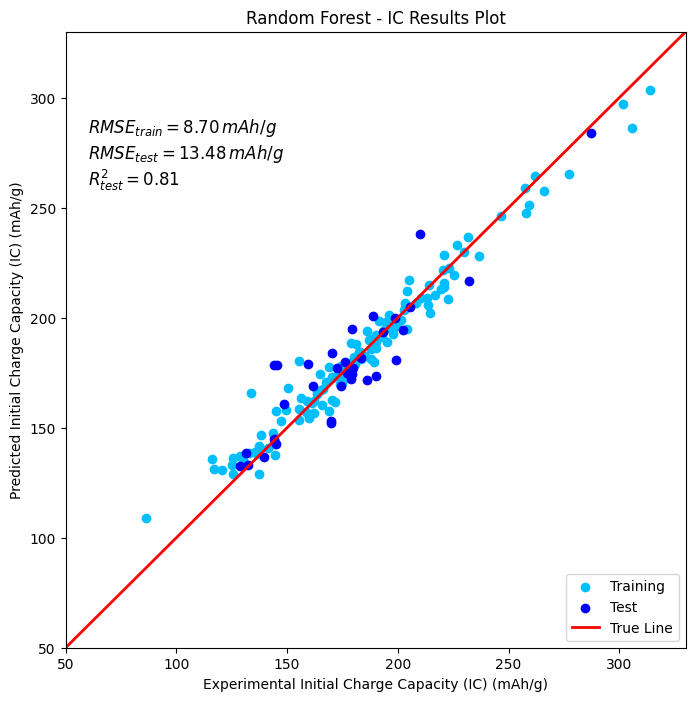

IC - Train RMSE: 8.70, Test RMSE: 13.48, R²: 0.81


In [ ]:
model_ic = RandomForestRegressor(n_estimators=100, random_state=42)
model_ic.fit(X_train, y_train_ic)

y_pred_ic_train = model_ic.predict(X_train)
y_pred_ic_test = model_ic.predict(X_test)

rmse_train_ic, rmse_test_ic, r2_ic = calculate_errors(y_train_ic, y_pred_ic_train, y_test_ic, y_pred_ic_test)
plot_IC_curve(y_train_ic, y_pred_ic_train, y_test_ic, y_pred_ic_test, rmse_train_ic, rmse_test_ic, r2_ic, "Random Forest")

print(f"IC - Train RMSE: {rmse_train_ic:.2f}, Test RMSE: {rmse_test_ic:.2f}, R²: {r2_ic:.2f}")

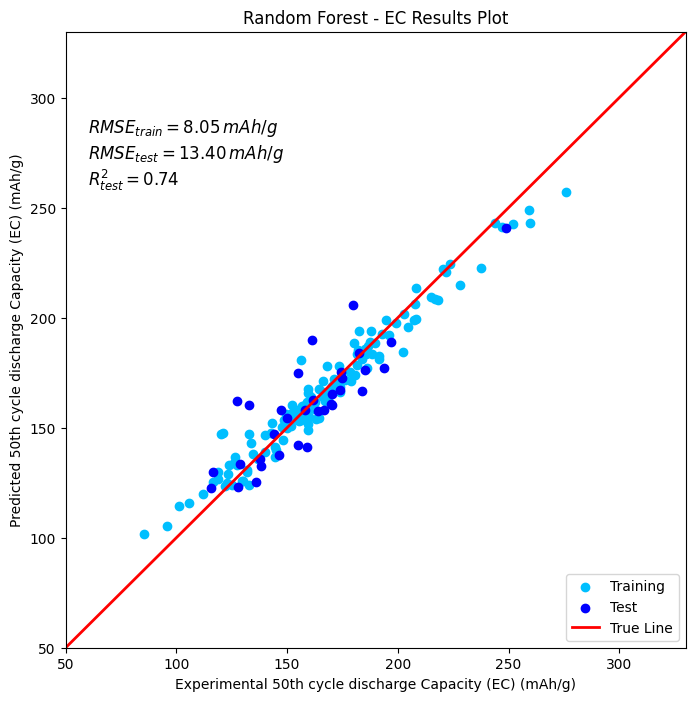

EC - Train RMSE: 8.05, Test RMSE: 13.40, R²: 0.74


In [16]:
model_ec = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model_ec.fit(X_train, y_train_ec)

y_pred_ec_train = model_ec.predict(X_train)
y_pred_ec_test = model_ec.predict(X_test)

rmse_train_ec, rmse_test_ec, r2_ec = calculate_errors(y_train_ec, y_pred_ec_train, y_test_ec, y_pred_ec_test)
plot_EC_curve(y_train_ec, y_pred_ec_train, y_test_ec, y_pred_ec_test, rmse_train_ec, rmse_test_ec, r2_ec, "Random Forest")

print(f"EC - Train RMSE: {rmse_train_ec:.2f}, Test RMSE: {rmse_test_ec:.2f}, R²: {r2_ec:.2f}")

# XGboost

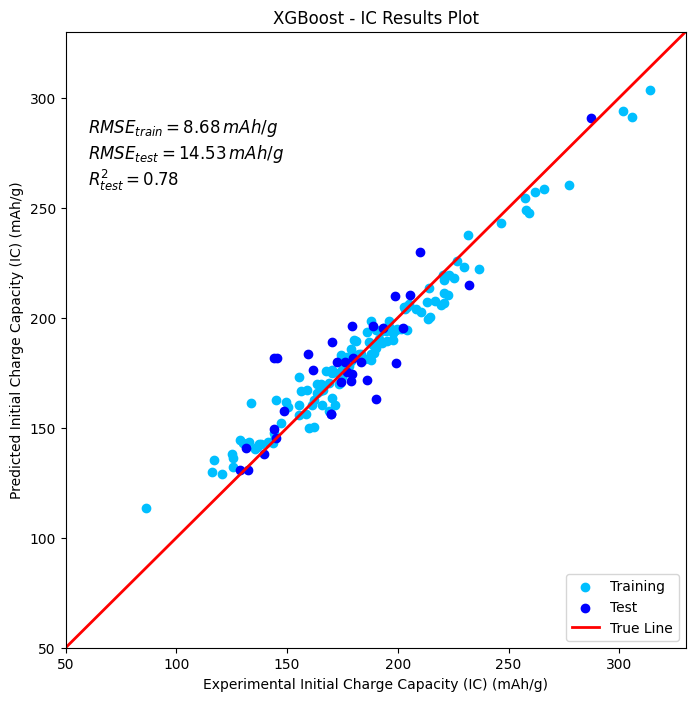

IC - Train RMSE: 8.68, Test RMSE: 14.53, R²: 0.78


In [17]:
model_ic = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.03, random_state=42)
model_ic.fit(X_train, y_train_ic)

y_pred_ic_train = model_ic.predict(X_train)
y_pred_ic_test = model_ic.predict(X_test)

rmse_train_ic, rmse_test_ic, r2_ic = calculate_errors(y_train_ic, y_pred_ic_train, y_test_ic, y_pred_ic_test)
plot_IC_curve(y_train_ic, y_pred_ic_train, y_test_ic, y_pred_ic_test, rmse_train_ic, rmse_test_ic, r2_ic, "XGBoost")

print(f"IC - Train RMSE: {rmse_train_ic:.2f}, Test RMSE: {rmse_test_ic:.2f}, R²: {r2_ic:.2f}")



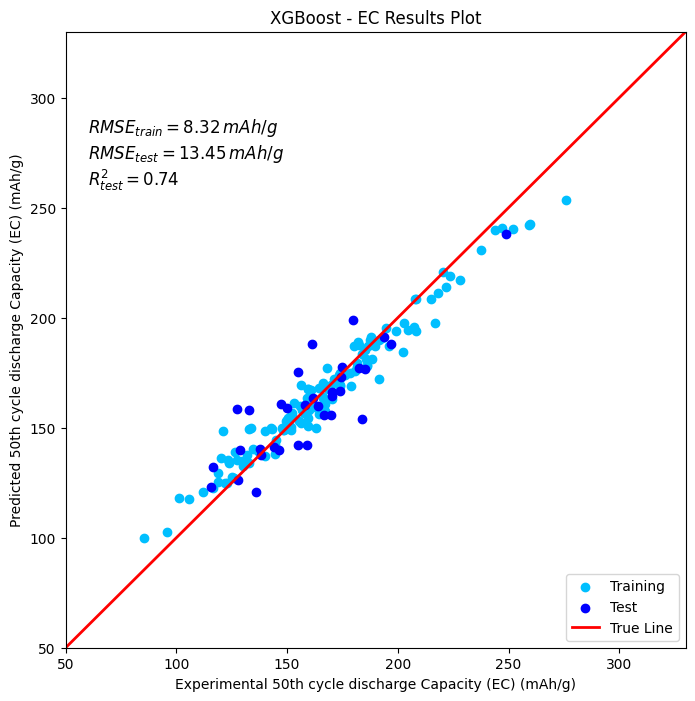

EC - Train RMSE: 8.32, Test RMSE: 13.45, R²: 0.74


In [18]:
model_ec = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.03, random_state=42)
model_ec.fit(X_train, y_train_ec)

y_pred_ec_train = model_ec.predict(X_train)
y_pred_ec_test = model_ec.predict(X_test)

rmse_train_ec, rmse_test_ec, r2_ec = calculate_errors(y_train_ec, y_pred_ec_train, y_test_ec, y_pred_ec_test)
plot_EC_curve(y_train_ec, y_pred_ec_train, y_test_ec, y_pred_ec_test, rmse_train_ec, rmse_test_ec, r2_ec, "XGBoost")

print(f"EC - Train RMSE: {rmse_train_ec:.2f}, Test RMSE: {rmse_test_ec:.2f}, R²: {r2_ec:.2f}")

# LGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.627613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1435325
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 59420
[LightGBM] [Info] Start training from score 185.647687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


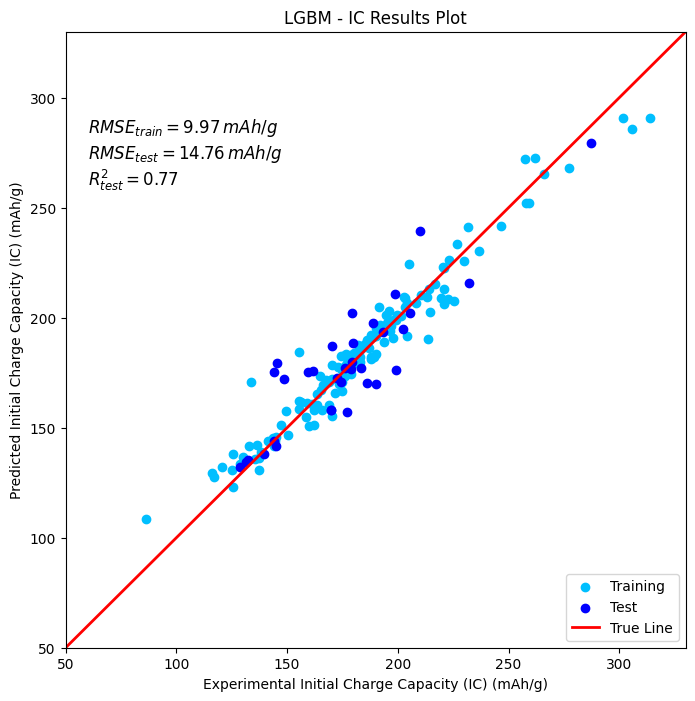

LGBM IC - Train RMSE: 9.97, Test RMSE: 14.76, R²: 0.77


In [ ]:
lgbm_ic = LGBMRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
lgbm_ic.fit(X_train, y_train_ic)
y_pred_ic_train = lgbm_ic.predict(X_train)
y_pred_ic_test = lgbm_ic.predict(X_test)

rmse_train_ic, rmse_test_ic, r2_ic = calculate_errors(y_train_ic, y_pred_ic_train, y_test_ic, y_pred_ic_test)
plot_IC_curve(y_train_ic, y_pred_ic_train, y_test_ic, y_pred_ic_test, rmse_train_ic, rmse_test_ic, r2_ic, "LGBM")

print(f"LGBM IC - Train RMSE: {rmse_train_ic:.2f}, Test RMSE: {rmse_test_ic:.2f}, R²: {r2_ic:.2f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.103462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1435325
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 59420
[LightGBM] [Info] Start training from score 166.005895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


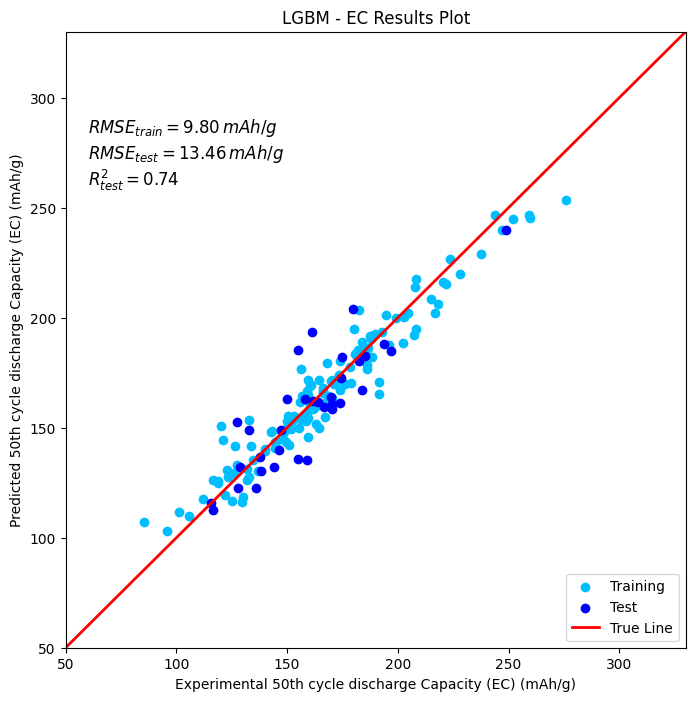

LGBM EC - Train RMSE: 9.80, Test RMSE: 13.46, R²: 0.74


In [ ]:
lgbm_ec = LGBMRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
lgbm_ec.fit(X_train, y_train_ec)
y_pred_ec_train = lgbm_ec.predict(X_train)
y_pred_ec_test = lgbm_ec.predict(X_test)

rmse_train_ec, rmse_test_ec, r2_ec = calculate_errors(y_train_ec, y_pred_ec_train, y_test_ec, y_pred_ec_test)
plot_EC_curve(y_train_ec, y_pred_ec_train, y_test_ec, y_pred_ec_test, rmse_train_ec, rmse_test_ec, r2_ec, "LGBM")

print(f"LGBM EC - Train RMSE: {rmse_train_ec:.2f}, Test RMSE: {rmse_test_ec:.2f}, R²: {r2_ec:.2f}")


# SVR

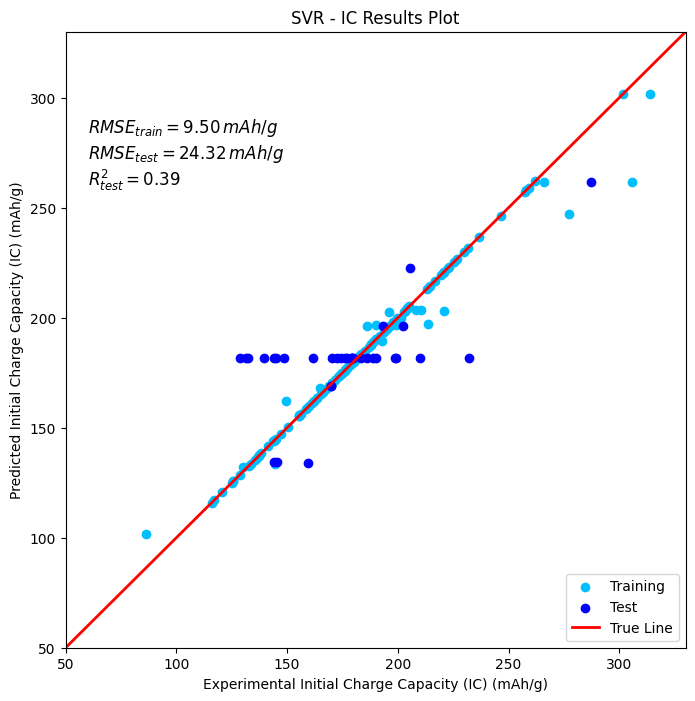

In [19]:
svr_model = SVR(kernel='rbf', C=80, gamma=0.01, epsilon=0.02)
svr_model.fit(X_train, y_train_ic)

y_train_pred = svr_model.predict(X_train)
y_test_pred = svr_model.predict(X_test)

rmse_train, rmse_test, r2_test = calculate_errors(y_train_ic, y_train_pred, y_test_ic, y_test_pred)
plot_IC_curve(y_train_ic, y_train_pred, y_test_ic, y_test_pred, rmse_train, rmse_test, r2_test, "SVR")

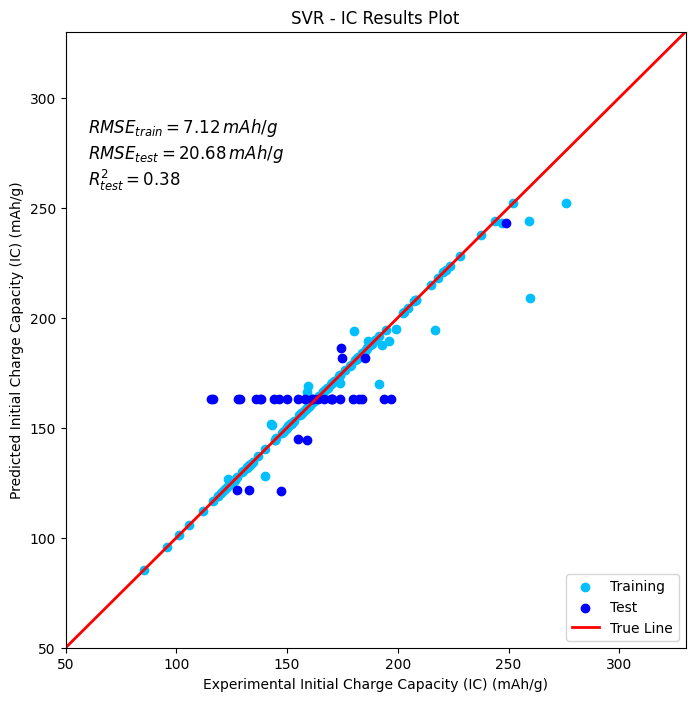

In [20]:
svr_model = SVR(kernel='rbf', C=80, gamma=0.01, epsilon=0.02)
svr_model.fit(X_train, y_train_ec)

y_train_pred = svr_model.predict(X_train)
y_test_pred = svr_model.predict(X_test)

rmse_train, rmse_test, r2_test = calculate_errors(y_train_ec, y_train_pred, y_test_ec, y_test_pred)
plot_IC_curve(y_train_ec, y_train_pred, y_test_ec, y_test_pred, rmse_train, rmse_test, r2_test, "SVR")